# Fuzzy numbers calculator

#### Important imports

In [1]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skfuzzy import trimf, trapmf
from typing import Union, Tuple, Type, List, Callable
from scipy.interpolate import interp1d
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
NUM = Union[float, int, np.float64, np.int64, np.int32, np.float32]

#### Definition of utility, that helps to perform user input validation

In [2]:
def check_container_type(obj: object, container_type: Type, expected_contents_types: List[Type]):
   return isinstance(obj, container_type) and\
          all(map(lambda tup: isinstance(tup[0], tup[1].__args__), zip(obj, expected_contents_types)))and\
          len(obj) == len(expected_contents_types)

#### Definition of exception

In [3]:
class UnsupportedOperationException(Exception):
    def __init__(self, *args):
        super().__init__(args)

### ApproximateLinearFuzzyNumber class
- Approximation of arithmetic operations is done using simple trapmf and trimf functions over computed output's fuzzy support
- It contains all arithmetic operations, that were expected in this task
- The analytical computations of fuzzy arithmetic will be presented at the end of this notebook

In [4]:
class ApproximateLinearFuzzyNumber(object):

    @staticmethod
    def compute_base(coeffs, type_: str, items=101, join=True):
        lower = min(coeffs)
        upper = max(coeffs)
        kernel_lower, kernel_upper = coeffs[1:-1] if type_=='trap' else (coeffs[1], coeffs[1])
        
        b = np.linspace(lower, upper, items if type_=='trap' else items-1)
        if type_=='tri':
            idx = b==kernel_lower
            if len(b[idx]) > 0:
                idx = np.hstack([idx, [False]])
                b = np.linspace(lower, upper, items)
                b = b[~idx]
        left = b[b < kernel_lower]
        kernel = b[(b >= kernel_lower) & (b <= kernel_upper)] if type_=='trap' else np.array([kernel_lower]) 
        try:
            kernel[0] = kernel_lower
        except:
            print(b, kernel_lower, kernel_upper)
        kernel[-1] = kernel_upper
        right = b[b > kernel_upper]
        base =  np.hstack([left, kernel, right]) if join else [left, kernel, right]
        if join:
            assert len(base) == items, f"{len(base)} != {items}; len of b {len(b)}; b= {b}"
        else:
            assert sum(list(map(len, base))) == items, f"{sum(list(map(len, base)))} != {items}; len of b {len(b)}; b= {b}"
        return base

    @staticmethod
    def compute_base_and_coeffs(coeffs: Union[Tuple[NUM, NUM, NUM], Tuple[NUM, NUM, NUM, NUM]], 
                                other_coeffs: Union[Tuple[NUM, NUM, NUM], Tuple[NUM, NUM, NUM, NUM]], 
                                op: str, elements=101):
        if not ((check_container_type(coeffs, tuple, [NUM,NUM,NUM]) or check_container_type(coeffs, tuple, [NUM,NUM,NUM,NUM])) and (
            check_container_type(other_coeffs, tuple, [NUM,NUM,NUM]) or check_container_type(other_coeffs, tuple, [NUM,NUM,NUM,NUM])
        )): raise UnsupportedOperationException("Cannot compute base and coefficients, invalid ranges provided")
        range_s = np.array([[coeffs[0]],[coeffs[-1]]], dtype=np.float64)
        range_f = np.array([other_coeffs[0],other_coeffs[-1]], dtype=np.float64)
        kernel_s = np.array(coeffs[1:-1], dtype=np.float64)
        kernel_f = np.array([other_coeffs[1:-1]], dtype=np.float64).T
        if op == '+':
            kernel_decision = kernel_s + kernel_f
            decision = range_s + range_f
        elif op == '-':
            kernel_decision = kernel_s - kernel_f
            decision = range_s - range_f
        elif op == '*':
            kernel_decision = kernel_s * kernel_f
            decision = range_s * range_f
        elif op == '/':
            kernel_decision = np.divide(kernel_s, kernel_f, out=np.zeros_like(kernel_s*kernel_f), where=kernel_f != 0)
            decision = np.divide(range_s, range_f, out=np.zeros_like(range_s*range_f), where=range_f != 0)
        else: raise UnsupportedOperationException(f"{op} - provided operator is not recognized, available operators: {{+, -, *, /}}")

        lower = np.min(decision)
        kernel_upper = np.max(kernel_decision)
        kernel_lower = np.min(kernel_decision)
        upper = np.max(decision)

        new_coeffs = []
        new_coeffs.append(lower)
        new_coeffs.append(kernel_lower)
        if kernel_upper != kernel_lower: new_coeffs.append(kernel_upper)
        new_coeffs.append(upper)

        return ApproximateLinearFuzzyNumber.compute_base(new_coeffs, 'trap' if len(new_coeffs) > 3 else 'tri', elements, False), tuple(new_coeffs)

    @property
    def name(self): return self.__name

    def __init__(self, coeffs: Union[Tuple[NUM, NUM, NUM], Tuple[NUM, NUM, NUM, NUM]], name: str, base: np.ndarray =None):
        self.__coeffs = coeffs
        self.__base = base
        self.__name = name
        if check_container_type(coeffs, tuple, [NUM, NUM, NUM]):
            try:
                self.__type = 'tri'
                if self.__base is None: self.__base = ApproximateLinearFuzzyNumber.compute_base(self.__coeffs, self.__type)
                self.__mf = trimf(self.__base, self.__coeffs)
            except:
                raise UnsupportedOperationException(f"Provided coefficients {self.__coeffs} does not satisfy"+
                                                          "condition: [x1,x2,x3] ->  x1<=x2<=x3 or x1<x2<=x3")
        elif check_container_type(coeffs, tuple, [NUM, NUM, NUM, NUM]):
            try:
                self.__type = 'trap'
                if self.__base is None: self.__base = ApproximateLinearFuzzyNumber.compute_base(self.__coeffs, self.__type)
                self.__mf = trapmf(self.__base, self.__coeffs)
            except:
                raise UnsupportedOperationException(f"Provided coefficients {self.__coeffs} does not satisfy "+
                                                          "condition: [x1,x2,x3,x4] -> x1<=x2<=x3<=x4")

        else: raise UnsupportedOperationException("Invalid coefficent tuple was provided to initialization procedure\n"+
                                                      f"type: {type(coeffs)}, elements: {list(map(type, coeffs))}")
        self.__membership_interpolator = Rbf(self.base, self.mi)

    def __set(self, new_mf: np.ndarray):
        if new_mf.shape != self.__base.shape: raise UnsupportedOperationException(f"Invalid transform, shapes-> "+
                                                                                  " Membership function: {new_mf.shape} != Shape: {self.__base.shape}")
        self.__mf = np.array(new_mf, copy=True)
        self.__membership_interpolator = Rbf(self.base, self.mi)

    def mf(self, num: NUM):
        if num >= self.__coeffs[0] and num <= self.__coeffs[-1]:
            return np.clip(self.__membership_interpolator(num), 0, 1)
        return 0.0

    @property
    def base(self): return np.array(self.__base, copy=True)
    
    @property
    def mi(self): return np.array(self.__mf, copy=True)

    @property
    def kernel(self): return np.array(self.__base[self.__mf == self.sup], copy=True)

    @property
    def sup(self): return max(self.__mf)

    @property
    def coef_(self): return tuple(np.array(self.__coeffs))

    def __invert__(self):
        if self.__coeffs[0] <= 0 and self.__coeffs[-1] >= 0: 
            raise UnsupportedOperationException("0-division error; the fuzzy number is irreversible - it is a fuzzy 0")

        b, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(tuple(np.ones_like(self.__coeffs)), 
                                                                         self.__coeffs, '/', len(self.__base))
        base = np.hstack(b)                                                                        
        out = ApproximateLinearFuzzyNumber(coeffs, f"({self.__name})^-1", base)
        return out
   
    def __neg__(self):
        base = np.array(sorted(-self.base))
        coeffs = tuple(sorted([-x for x in self.__coeffs]))
        out = ApproximateLinearFuzzyNumber(coeffs, f"- ({self.__name})", base)
        return out 

    @property
    def complement(self):
        out = ApproximateLinearFuzzyNumber(self.__coeffs, f"({self.__name})'", self.__base)
        out.__type = f"complement of {out.__type}"
        out.__set(self.sup - self.__mf)
        return out  
    
    def __abs__(self):
        if all([coef >= 0 for coef in self.coef_]):
            return ApproximateLinearFuzzyNumber(self.__coeffs, f"|{self.__name}|", self.__base)
        if all([coef <= 0 for coef in self.coef_]):
            _neg = -self
            _neg.__name = f"|{self.__name}|"
            return _neg
        old = self.coef_
        abs_old = list((np.abs(old)))
        removed = 0
        if abs_old[0] > abs_old[-1]:
            abs_old.remove(abs_old[-1])
        else: abs_old.remove(abs_old[0])   
        removed += 1

        new_coeffs = tuple(sorted(set(abs_old + [0])))

        b = ApproximateLinearFuzzyNumber.compute_base(new_coeffs, "tri" if len(new_coeffs) == 3 else 'trap', join=True, items=len(self.base)-1)
        b = np.hstack([[-1e-6], b])
        m = np.array([0 if x < 0 else max(self.mf(x), self.mf(-x)) for x in b])

        if len(new_coeffs) > 3:
            abs_old.remove(min(abs_old[1:]))
            removed += 1
        new_coeffs = tuple(sorted(abs_old + removed*[0]))
        
        _abs = ApproximateLinearFuzzyNumber(new_coeffs, f"|{self.__name}|", b)
        _abs.__set(m)
        return _abs

    def __sub__(self, fuzzy_num: Union[ApproximateLinearFuzzyNumber, NUM]):
        if isinstance(fuzzy_num, ApproximateLinearFuzzyNumber):
            return self.__sub_f(fuzzy_num)

        if isinstance(fuzzy_num, NUM.__args__):
            return self.__sub_r(fuzzy_num)
        raise NotImplementedError 

    def __sub_r(self, num: NUM):
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, 
                                                                 tuple(num*np.ones_like(self.__coeffs)), '-', 
                                                                 len(self.__base))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"{self.__name} - {num}", base)
        return out

    def __sub_f(self, fuzzy_num: ApproximateLinearFuzzyNumber):
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, fuzzy_num.__coeffs, '-', 
                                                                 min(len(self.__base), len(fuzzy_num.__base)))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"{self.__name} - {fuzzy_num.name}", base)
        return out

    def __add__(self, fuzzy_num: Union[ApproximateLinearFuzzyNumber, NUM]):
        if isinstance(fuzzy_num, ApproximateLinearFuzzyNumber):
            return self.__add_f(fuzzy_num)

        if isinstance(fuzzy_num, NUM.__args__):
            return self.__add_r(fuzzy_num)
        raise NotImplementedError
    
    def __add_r(self, num: NUM):
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, 
                                                                 tuple(num*np.ones_like(self.__coeffs)), '+', 
                                                                 len(self.__base))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"{self.__name} + {num}", base)
        return out
                                                                        
    def __add_f(self, fuzzy_num: ApproximateLinearFuzzyNumber):
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, fuzzy_num.__coeffs, '+', 
                                                                 min(len(self.__base), len(fuzzy_num.__base)))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"{self.__name} + {fuzzy_num.name}", base)
        return out

    def __mul__(self, fuzzy_num: Union[ApproximateLinearFuzzyNumber, NUM]):
        if isinstance(fuzzy_num, ApproximateLinearFuzzyNumber):
            return self.__mul_f(fuzzy_num)

        if isinstance(fuzzy_num, NUM.__args__):
            return self.__mul_r(fuzzy_num)
        raise NotImplementedError
    
    def __mul_r(self, num: NUM):
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, 
                                                                 tuple(num*np.ones_like(self.__coeffs)), '*', 
                                                                 len(self.__base))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"({self.__name}) * ({num})", base)
        return out
    
    def __mul_f(self, fuzzy_num: ApproximateLinearFuzzyNumber):
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, fuzzy_num.__coeffs, '*', 
                                                                 min(len(self.__base), len(fuzzy_num.__base)))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"({self.__name}) * ({fuzzy_num.name})", base)
        return out

    def __truediv__(self, fuzzy_num: Union[ApproximateLinearFuzzyNumber, NUM]):
        if isinstance(fuzzy_num, ApproximateLinearFuzzyNumber):
            return self.__div_f(fuzzy_num)

        if isinstance(fuzzy_num, NUM.__args__):
            return self.__div_r(fuzzy_num)
        raise NotImplementedError

    def __div_r(self, num: NUM):
        if num == 0 or num <= 1e-8: 
            raise UnsupportedOperationException("0-division error; provided scalar is 0-like")
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, 
                                                                 tuple(num*np.ones_like(self.__coeffs)), '/', 
                                                                 len(self.__base))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"({self.__name}) / ({num})", base)
        return out
    
    def __div_f(self, fuzzy_num: ApproximateLinearFuzzyNumber):
        if fuzzy_num.__coeffs[0] <= 0 and fuzzy_num.__coeffs[-1] >= 0: 
            raise UnsupportedOperationException("0-division error; the fuzzy denominator is a fuzzy 0")
        new_base, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(self.__coeffs, fuzzy_num.__coeffs, '/', 
                                                                 min(len(self.__base), len(fuzzy_num.__base)))
        base = np.hstack(new_base)
        out = ApproximateLinearFuzzyNumber(coeffs, f"({self.__name}) / ({fuzzy_num.name})", base)
        return out
    
    def plot(self, ax=None, label: str="", **plt_kwargs):
        show = False
        if ax is None: fig, ax = plt.subplots(figsize=(6,6));show=True
        ax.plot(self.base, self.mi, label=(label if label != "" and label is not None else self.name), **plt_kwargs)
        ax.legend()
        if show: plt.show()
    
    def __repr__(self):
        self.plot()
        return f"<{self.__module__}.{type(self).__name__} object at ({hex(id(self))})>"

### Presentation of arithmetic of two fuzzy numbers

#### Definition of 'A'

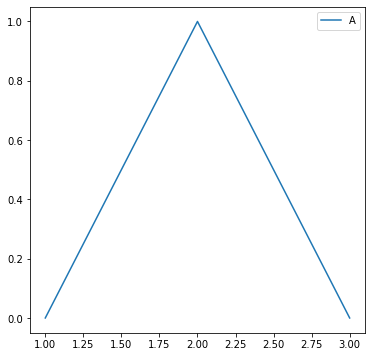

<__main__.ApproximateLinearFuzzyNumber object at (0x2cfe1e78808)>

In [5]:
A = ApproximateLinearFuzzyNumber((1,2,3), "A")
A

#### Definition of 'B'

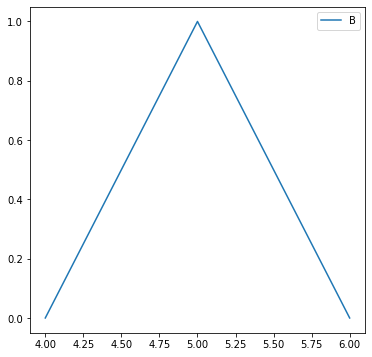

<__main__.ApproximateLinearFuzzyNumber object at (0x2cfe1e78408)>

In [6]:
B = (ApproximateLinearFuzzyNumber((4,5,6), "B"))
B

#### Fuzzy addition

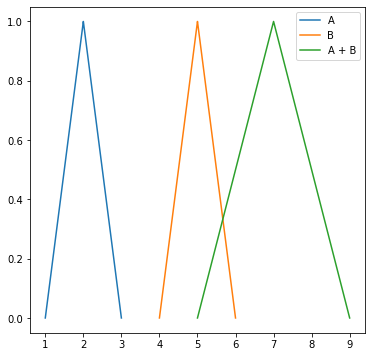

In [7]:
A_add_B = A+B
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
B.plot(ax=ax)
A_add_B.plot(ax=ax)
plt.show()

#### Fuzzy subtraction

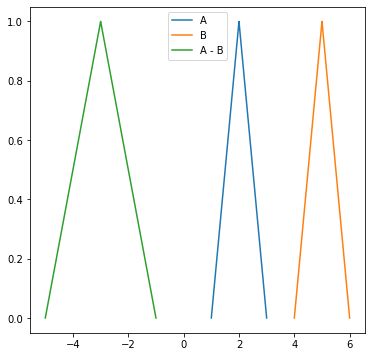

In [8]:
A_sub_B = A-B
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
B.plot(ax=ax)
A_sub_B.plot(ax=ax)
plt.show()

#### Fuzzy multiplication

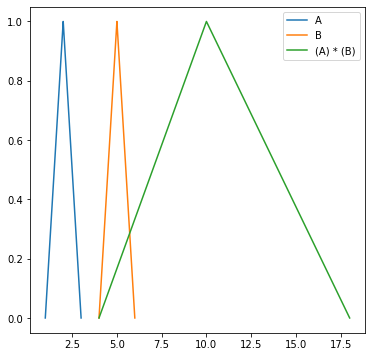

In [9]:
A_mul_B = A*B
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
B.plot(ax=ax)
A_mul_B.plot(ax=ax)
plt.show()

#### Fuzzy division

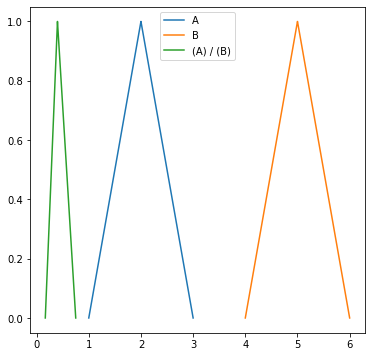

In [10]:
A_div_B = A/B
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
B.plot(ax=ax)
A_div_B.plot(ax=ax)
plt.show()

### Presentation of fuzzy one-argument arithmetics

#### Fuzzy absolute value

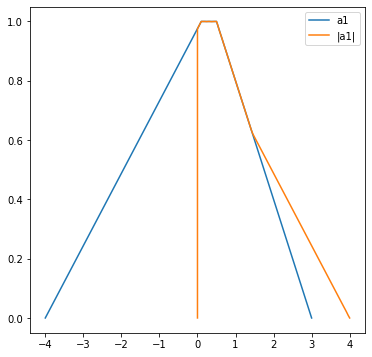

In [11]:
a1 = ApproximateLinearFuzzyNumber((-4,0.1, 0.5,3), 'a1')
fig, ax = plt.subplots(figsize=(6,6))
a1.plot(ax=ax)
a1_abs = abs(a1)
a1_abs.plot(ax=ax)
plt.show()

#### Fuzzy inversion

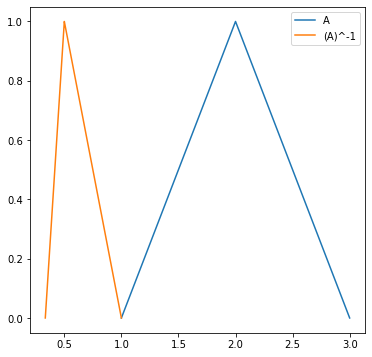

In [12]:
A_inv = ~A
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
A_inv.plot(ax=ax)
plt.show()

#### Mirror of fuzzy number

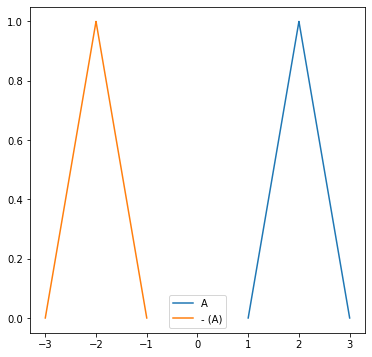

In [13]:
A_neg = -A
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
A_neg.plot(ax=ax)
plt.show()

### Presentation of arithmetic of scalar and fuzzy number

#### Fuzzy addition

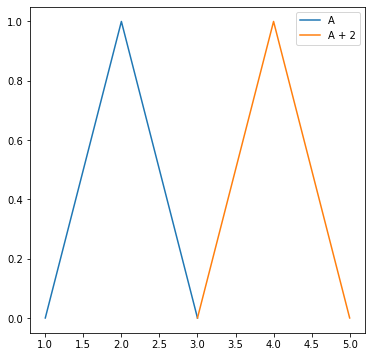

In [14]:
A_add_2 = A+2
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
A_add_2.plot(ax=ax)
plt.show()

#### Fuzzy subtraction

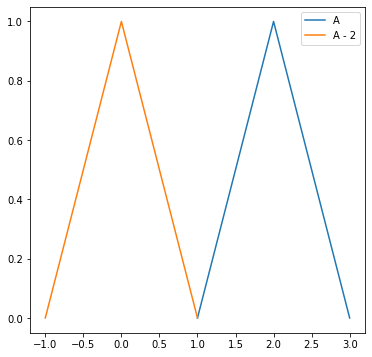

In [15]:
A_sub_2 = A-2
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
A_sub_2.plot(ax=ax)
plt.show()

#### Fuzzy multiplication

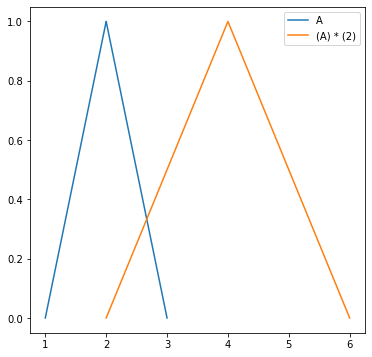

In [16]:
A_mul_2 = A*2
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
A_mul_2.plot(ax=ax)
plt.show()

#### Fuzzy division

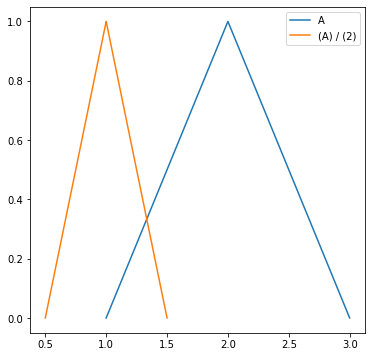

In [17]:
A_div_2 = A/2
fig, ax = plt.subplots(figsize=(6,6))
A.plot(ax=ax)
A_div_2.plot(ax=ax)
plt.show()

### Analytic computations of fuzzy arithmetic
- it's hard to implement all functions and operations on fuzzy numbers since, sometimes it impossible to conduct resulting functions of fuzzy number

#### Fuzzy inversion, and comparison with obtained result in previous chapter

d:\Projects\SI\Lab6\lab6_env\lib\site-packages\scipy\interpolate\rbf.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=4.78453e-19): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


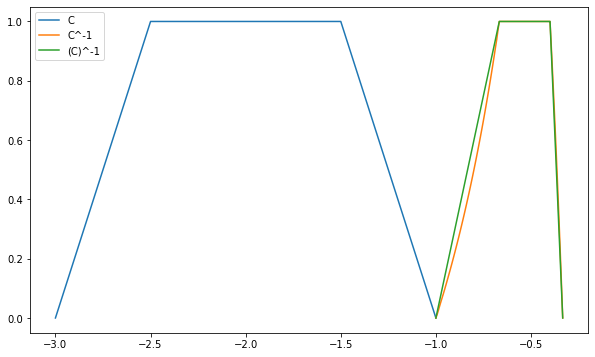

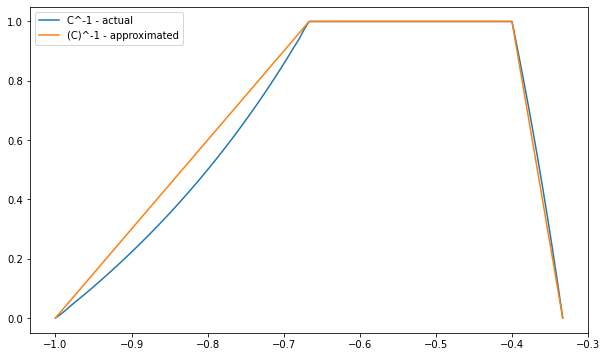

In [18]:
C = ApproximateLinearFuzzyNumber((-3,-2.5, -1.5, -1), 'C')
b, coeffs = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(tuple(np.ones_like(C.coef_)), C.coef_, '/', len(C.base))
left, kernel, right = b
mf_right = [C.mf(1/x) for x in right]
mf_left = [C.mf(1/x) for x in left]
base = np.hstack([left, kernel, right])
mf = np.clip(np.hstack([mf_left, np.ones_like(kernel), mf_right]), 0, 1)

fig, ax = plt.subplots(figsize=(10,6))
C.plot(ax=ax)
ax.plot(base, mf, label='C^-1')
ax.legend()
inv_C = ~C
inv_C.plot(ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(base, mf, label='C^-1 - actual')
ax.legend()
inv_C.plot(ax=ax, label=f"{inv_C.name} - approximated")

#### Fuzzy multiplication

In [19]:
def fit_to_arr(arr, new_size):
    arr1_interp = interp1d(np.arange(arr.size), arr)
    arr1_compress = arr1_interp(np.linspace(0,arr.size-1,new_size))
    return arr1_compress

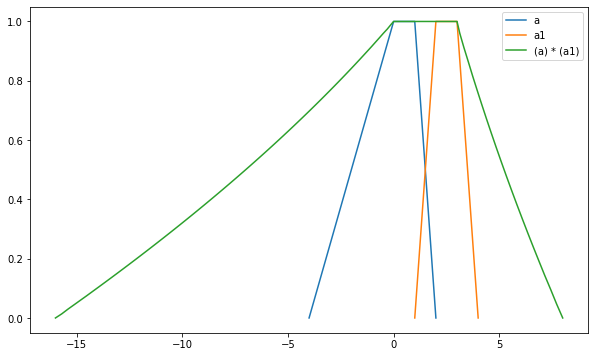

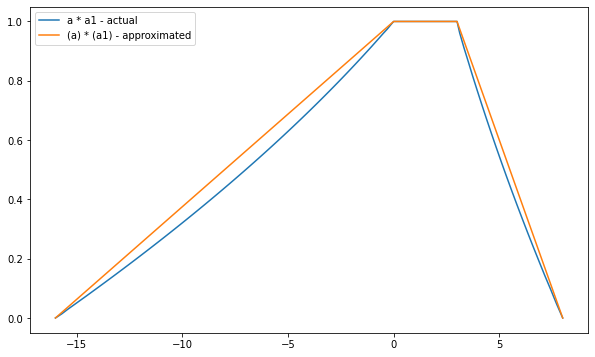

In [20]:
a =  ApproximateLinearFuzzyNumber((-4, 0, 1, 2), 'a')
a1 = ApproximateLinearFuzzyNumber((1,2,3,4), 'a1')

l_a, r_a = a.base[a.base < 0], a.base[a.base > 1]
lr_a1 = a1.base[a1.base > 3]
bb, cc = ApproximateLinearFuzzyNumber.compute_base_and_coeffs(a.coef_, a1.coef_, '*')
l_bb, k_bb, r_bb = bb
n_l_a = fit_to_arr(l_a, len(l_bb))
n_l_a1 = fit_to_arr(lr_a1, len(l_bb))
n_r_a = fit_to_arr(r_a, len(r_bb))
n_r_a1 = fit_to_arr(lr_a1, len(r_bb))

xx_l, yy_l = np.meshgrid(n_l_a, n_l_a1)
zz_l = np.zeros_like(xx_l)
mm_l = np.zeros_like(xx_l)

for j in range(len(n_l_a)):
    for i in range(len(n_l_a1)):
        mm_l[i, j] = (min(a.mf(n_l_a[j]), a1.mf(n_l_a1[i])))
        zz_l[i, j] = xx_l[i,j] * yy_l[i,j]

left = np.diagonal(np.rot90(zz_l))

d_arg = np.argsort(left)
left = np.sort(left)

mm_l = np.diagonal(np.rot90(mm_l, 1))[d_arg]


xx_r, yy_r = np.meshgrid(n_r_a, n_r_a1)
zz_r = np.zeros_like(xx_r)
mm_r = np.zeros_like(xx_r)

for j in range(len(n_r_a)):
    for i in range(len(n_r_a1)):
        mm_r[i, j] = (min(a.mf(n_r_a[j]), a1.mf(n_r_a1[i])))
        zz_r[i, j] = xx_r[i,j] * yy_r[i,j]

right = np.diagonal((zz_r))

d_arg = np.argsort(right)
right = np.sort(right)

mm_r = np.diagonal((mm_r))[d_arg]

base = np.hstack([left, k_bb, right])
mf = np.hstack([mm_l, np.ones_like(k_bb), mm_r])
fig, ax = plt.subplots(figsize=(10,6))
a.plot(ax=ax)
a1.plot(ax=ax)
ax.plot(base, mf, label=f"({a.name}) * ({a1.name})")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(base, mf, label='a * a1 - actual')
ax.legend()
mul = a*a1
mul.plot(ax=ax, label=f"{mul.name} - approximated")

### Calculator
- Run this cell to perform calculations and interaction.


(1.0, 2.0, 3.0)


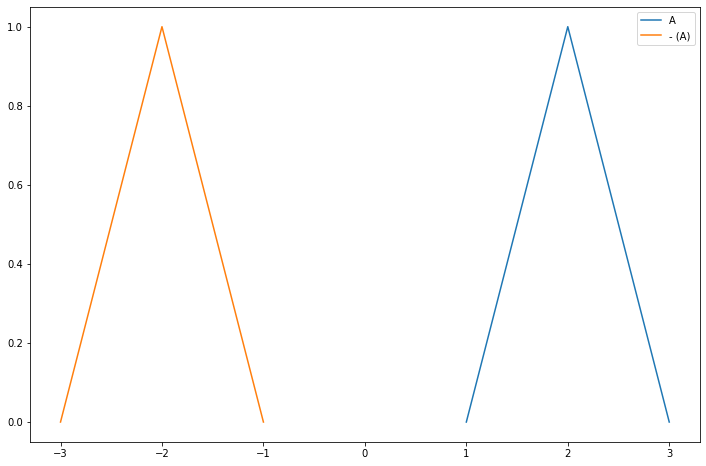

In [31]:
values1 = tuple([float(item) for item in input("Enter coefficients of linear fuzzy number, numbers have to be separated"+
                    " by space and in ascending order eg: -4 0 7 8 ").split()])
print(values1)
A = ApproximateLinearFuzzyNumber(values1, 'A')
operator = input("Provide operator (+, /, *, -, ~, abs)")

assert operator in ['+', '/', '-', '~', 'abs']
b_computed = False
if operator == '-':
    result = input("Do you want to provide another fuzzy number - 'True', or compute mirror/image of fuzzy number - 'False'?")
    if result == 'True':
        values2 = tuple([float(item) for item in input("Enter coefficients of linear fuzzy number, numbers have to be separated"+
                    " by space and in ascending order eg: -4 0 7 8 ").split()])
        print(values2)
        B = ApproximateLinearFuzzyNumber(values2, 'B')
        rV = A - B
        b_computed = True

    else:
        rV = -A
elif operator == '~':
    rV = ~A
elif operator == 'abs':
    rV = abs(A)
elif operator in ['+', '*', '/']:
    values2 = tuple([float(item) for item in input("Enter coefficients of linear fuzzy number, numbers have to be separated"+
                    " by space and in ascending order eg: -4 0 7 8 ").split()])
    print(values2)
    B = ApproximateLinearFuzzyNumber(values2, 'B')

    if operator == '+':
        rV = A+B
    elif operator == '*':
        rV = A*B
    elif operator == '/':
        rV = A/B
    b_computed = True

else: raise UnsupportedOperationException("Error internal")

fig, ax = plt.subplots(figsize=(12, 8))
A.plot(ax=ax)
if b_computed: B.plot(ax=ax)
rV.plot(ax=ax)

True